In [19]:
import sys
sys.path.append('../src/')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from LEC import Lec

from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.datasets import load_boston
from sklearn.datasets import make_blobs

from sklearn.naive_bayes import GaussianNB
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError

from sklearn.metrics import accuracy_score

from utils import unlabel

from river import drift

def chunk_indexes(iterator,size=5000):
    
    idxs = list(range(0,len(iterator),size))
        
    if len(iterator) not in idxs:
        idxs = idxs + [len(iterator)]
    
    idxs = [(idxs[i],idxs[i+1]) for i in range(0, len(idxs) - 1) ]
    return idxs

#TODO Melhorar o racional do KL Divergence
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def is_fitted(model):
    try:
        check_is_fitted(model)
        response = True
        
    except NotFittedError:
        response = False
        
    return response

def chunk_where(X,y,unlabelled = False):
    if unlabelled:
        mask_label = y == -1
        
    else:
        mask_label = y != -1
        
    return X[mask_label],y[mask_label]

In [20]:
#df = pd.read_csv('../data/covtype/covtype.data.gz',header=None)
df = pd.read_csv('../data/electricity/electricity_nomalized.csv',header=None)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [23]:
y = y.replace({'DOWN':0,
               'UP':1})

In [54]:
# import random
# rnd_indx = random.choices(population = df.index,k = 1000)

# rnd_df = df.iloc[rnd_indx]
# rnd_X = rnd_df.iloc[:,:-1]
# rnd_y = rnd_df.iloc[:,-1]

# incremental_cls = GaussianNB()
# incremental_cls.fit(rnd_X,rnd_y)

incremental_cls = GaussianNB()

drift_detector = drift.ADWIN()

K = 20
Q = 10
THRESHOLD = 0.9
idxs = chunk_indexes(X,size=5000)
cncpt_drift = False
drifts = []

acc_scores = []
for step, batch_bound in enumerate(idxs):
    
    #Separacao dos dados e introducao de ruido na target
    Di = X.iloc[batch_bound[0]:batch_bound[1],:]
    y_chunk = y.iloc[batch_bound[0]:batch_bound[1]]
    y_unl= unlabel(y_chunk,frac = 0.9)

    if step == 0:
        #seleciona só dados rotulados para treinamento inicial 
        assert not is_fitted(incremental_cls)
        Di_labelled,y_labelled = chunk_where(Di,y_chunk,unlabelled = False)
        incremental_cls.fit(Di_labelled,y_labelled)
        print('Criação do modelo Inicial executado com sucesso!')
        
    ###################################################
    #TODO: Detector de medidor de conceito
    if cncpt_drift and step !=0 :
        incremental_cls = GaussianNB() #restarta modelo
    
        print('Training Supervised Classifier')
        #filtra somente os dados rotulados
#       X_labeled = 
#       y_labeled =
        
        incremental_cls.fit(X_labeled,y_labeled)
        psd_chunk = pd.DataFrame()
    ###################################################
    else:
            
        #LEC Prediction in Di
        c_ens = Lec(y_r = y_unl, Q=Q, Di=Di)
        ###################################################
        #TODO: Concertar o fato de pegar a PRIMEIRA Mode
        LEC_pred = c_ens.fit_transform(K=K).mode(axis=1)[0]
        ###################################################
        
        #predict nos dados nao rotulados com classificador
        cls_pred = incremental_cls.predict_proba(Di) #desta forma fazemos o predict na base toda
        
        S_all =pd.concat([pd.Series(y_unl,name='labels'),
           pd.Series(LEC_pred,name='LEC'),
           #TODO: pode ser interessante ter a confidence do LEC tbm
           pd.Series(np.argmax(cls_pred,axis=1), name='CLS'),
           pd.Series(np.max(cls_pred,axis=1), name='conf_CLS')],
           axis=1)

        S = S_all[S_all['LEC'] == S_all['CLS']].sort_values(by='conf_CLS',ascending=False)
        R = S[S['conf_CLS'] > THRESHOLD]
        
        Di_psd_chunk = Di.iloc[R.index]
        y_psd_chunk = y_chunk.iloc[R.index]
            
        if step > 0:
            
            Di_labelled,y_labelled = chunk_where(Di,y_chunk,unlabelled = False)
            
            Di_labelled = pd.concat([Di_labelled,Di_psd_chunk])
            yi_labelled = pd.concat([y_labelled,y_psd_chunk])
            incremental_cls.partial_fit(Di_labelled,yi_labelled)

        ############################## BOnus
        #forca retreino do classificador
        ###########################    
    
    print(f'Step: {step+1} Finished')
    
    #Métrica do modelo só em dados não rotulados
    D_u, _ = chunk_where(Di, y_unl, unlabelled = True)
    y_u = y_chunk[D_u.index]
    
    D_u_cls_pred = incremental_cls.predict(D_u)
    acc_scores.append(accuracy_score(y_u, D_u_cls_pred))
    print(acc_scores)

Criação do modelo Inicial executado com sucesso!
Step: 1 Finished
[0.8136645962732919]
Step: 2 Finished
[0.8136645962732919, 0.7945115257958287]
Step: 3 Finished
[0.8136645962732919, 0.7945115257958287, 0.7994652406417112]
Step: 4 Finished
[0.8136645962732919, 0.7945115257958287, 0.7994652406417112, 0.7602313167259787]
Step: 5 Finished
[0.8136645962732919, 0.7945115257958287, 0.7994652406417112, 0.7602313167259787, 0.7024866785079928]
Step: 6 Finished
[0.8136645962732919, 0.7945115257958287, 0.7994652406417112, 0.7602313167259787, 0.7024866785079928, 0.6416184971098265]
Step: 7 Finished
[0.8136645962732919, 0.7945115257958287, 0.7994652406417112, 0.7602313167259787, 0.7024866785079928, 0.6416184971098265, 0.607229446770994]
Step: 8 Finished
[0.8136645962732919, 0.7945115257958287, 0.7994652406417112, 0.7602313167259787, 0.7024866785079928, 0.6416184971098265, 0.607229446770994, 0.792326567031006]
Step: 9 Finished
[0.8136645962732919, 0.7945115257958287, 0.7994652406417112, 0.7602313167

### Incremental learning - Naive Bayes

In [50]:
banch_scores = []
for step, batch_bound in enumerate(idxs):
    
    #Separacao dos dados e introducao de ruido na target
    Di = X.iloc[batch_bound[0]:batch_bound[1],:]
    y_chunk = y.iloc[batch_bound[0]:batch_bound[1]]
    y_unl= unlabel(y_chunk,frac = 0.9)
    
    #seleciona só dados rotulados para treinamento inicial 
    Di_labelled,y_labelled = chunk_where(Di,y_chunk,unlabelled = False)
    
    if step == 0:
        incremental_cls.fit(Di_labelled,y_labelled)
    else:
        incremental_cls.partial_fit(Di_labelled,y_labelled)
        
    print(f'Step: {step+1} Finished')
    
    #Métrica do modelo só em dados não rotulados
    D_u, _ = chunk_where(Di, y_unl, unlabelled = True)
    
    y_u = y_chunk[D_u.index]
    D_u_cls_pred = incremental_cls.predict(D_u)
    banch_scores.append(accuracy_score(y_u, D_u_cls_pred))
    print(banch_scores)

Step: 1 Finished
[0.8147818343722173]
Step: 2 Finished
[0.8147818343722173, 0.7968611847922192]
Step: 3 Finished
[0.8147818343722173, 0.7968611847922192, 0.7932724437513923]
Step: 4 Finished
[0.8147818343722173, 0.7968611847922192, 0.7932724437513923, 0.7448123620309051]
Step: 5 Finished
[0.8147818343722173, 0.7968611847922192, 0.7932724437513923, 0.7448123620309051, 0.7069081153588196]
Step: 6 Finished
[0.8147818343722173, 0.7968611847922192, 0.7932724437513923, 0.7448123620309051, 0.7069081153588196, 0.6362632508833922]
Step: 7 Finished
[0.8147818343722173, 0.7968611847922192, 0.7932724437513923, 0.7448123620309051, 0.7069081153588196, 0.6362632508833922, 0.604194556001785]
Step: 8 Finished
[0.8147818343722173, 0.7968611847922192, 0.7932724437513923, 0.7448123620309051, 0.7069081153588196, 0.6362632508833922, 0.604194556001785, 0.7826569084054114]
Step: 9 Finished
[0.8147818343722173, 0.7968611847922192, 0.7932724437513923, 0.7448123620309051, 0.7069081153588196, 0.6362632508833922, 

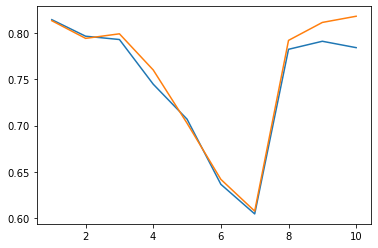

In [56]:
plt.plot(range(1,len(banch_scores)+1),banch_scores)
plt.plot(range(1,len(acc_scores)+1),acc_scores)